In [35]:
''' Bernoulli Naive Bayes model where the features are represented in terms of 1, if present and 0, if absent 
in the document based on vocabulary we build
This model involves IMDB review data, which was preprocessed to be included in one single document called "imdb_all.csv"
'''

' Bernoulli Naive Bayes model where the features are represented in terms of 1, if present and 0, if absent \nin the document based on vocabulary we build\nThis model involves IMDB review data, which was preprocessed to be included in one single document called "imdb_all.csv"\n'

In [21]:
#import all required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline                                 
from IPython.core.debugger import set_trace  
import scipy.sparse as sparse
import seaborn as sns

np.random.seed(1234)

In [22]:
#import dataset
df = pd.read_csv('imdb_all.csv', delimiter = ';')

In [23]:
print('Dimensions of the whole dataset:', df.shape)
print('\nFirst 3 rows of the dataset:\n', df.iloc[:3])

Dimensions of the whole dataset: (50000, 4)

First 3 rows of the dataset:
                                               review dataset label  rating
0  alan rickman & emma thompson give good perform...    test   neg       4
1  i have seen this movie and i did not care for ...    test   neg       1
2  in los angeles the alcoholic and lazy hank chi...    test   neg       4


In [24]:
#import stopwords from nltk(a natural language processing library)
import nltk
import string

nltk.download("stopwords")
from nltk.corpus import stopwords
stop = set(stopwords.words("english"))

#Adding all the above lists and inclusing punctuations to syop words
stop_words = list(stop)+list(set(string.punctuation))
print("length of stopwords to be removed from our vocabulary: ",str(len(stop_words)))

length of stopwords to be removed from our vocabulary:  211


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
train_label = []
test_label = []
reviews_train = df.loc[df["dataset"] == 'train', "review"]
y_train = df.loc[df["dataset"] == 'train', "label"]
y_train = y_train.replace({'neg': 0, 'pos': 1})

reviews_test = df.loc[df["dataset"] == 'test', "review"]
y_test = df.loc[df["dataset"] == 'test', "label"]
y_test = y_test.replace({'neg': 0, 'pos': 1})

train_label = y_train.to_numpy()
test_label = y_test.to_numpy()
print(reviews_train.shape, y_train.shape, reviews_test.shape, y_test.shape)
print('\nreviews_train:\n', reviews_train.head(n=2), '\ny_train:\n', y_train.head(n=2), '\nreviews_test:\n', reviews_test.head(n=2), '\ny_test:\n', y_test.head(n=2))

(25000,) (25000,) (25000,) (25000,)

reviews_train:
 25000    working with one of the best shakespeare sourc...
25001    welltremors i the original started off in 1990...
Name: review, dtype: object 
y_train:
 25000    0
25001    0
Name: label, dtype: int64 
reviews_test:
 0    alan rickman & emma thompson give good perform...
1    i have seen this movie and i did not care for ...
Name: review, dtype: object 
y_test:
 0    0
1    0
Name: label, dtype: int64


# **Data Exploration**

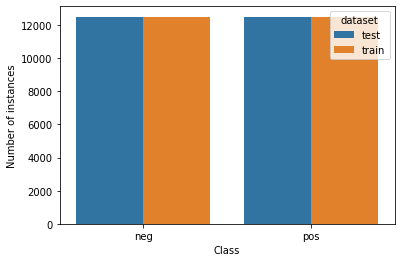

In [27]:
#Plot class distribution
ax = sns.countplot(x='label', hue ='dataset', data=df)
ax.set(xlabel='Class', ylabel='Number of instances')
#plt.savefig(path+'/figures/imdb_labels.png')
plt.show()

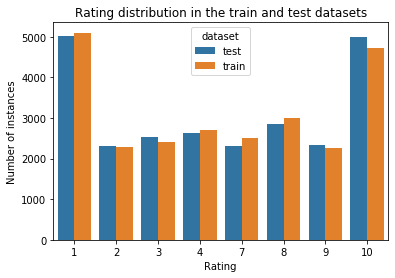

In [28]:
#PLot the rating distribution
ax = sns.countplot(x='rating', hue ='dataset', data=df)
ax.set(xlabel='Rating', ylabel='Number of instances', title='Rating distribution in the train and test datasets')
#plt.savefig(path+'/figures/imdb_ratings.png')
plt.show()

In [29]:
#Test vectorization
'''1. Using basic stop words
Create the feature matrices x_train and x_test: rows=instances, columns=words, 

*   List item
*   List item

values=Present/Absent
'''
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(binary=True, stop_words=['in','of','at','a','the'])
x_train = count_vect.fit_transform(reviews_train)
print(x_train.shape)
x_test = count_vect.transform(reviews_test)
print(x_test.shape)

(25000, 92711)
(25000, 92711)


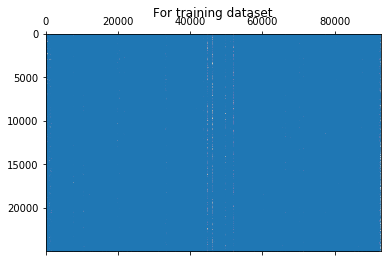

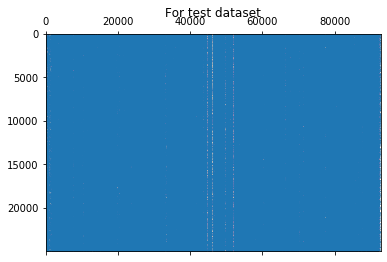

In [32]:
#Visualize the sparse matrix (blue dots are non-zero values).
plt.spy(x_train, markersize=0.05, aspect='auto')
plt.title("For training dataset")
plt.show()
plt.spy(x_test, markersize=0.05, aspect='auto')
plt.title("For test dataset")
plt.show()

In [33]:
#Vectorizing using bigrams
count_vect_bigrams = CountVectorizer(binary=True, ngram_range=(1, 2), stop_words=['in','of','at','a','the'])
x_train_bigrams = count_vect_bigrams.fit_transform(reviews_train)
print(x_train_bigrams.shape)
x_test_bigrams = count_vect_bigrams.transform(reviews_test)
print(x_test_bigrams.shape)

(25000, 1729766)
(25000, 1729766)


In [34]:
#Vectorizing using word count
freq_vect = CountVectorizer(ngram_range=(1, 2), stop_words=['in','of','at','a','the'])
x_train_freq = freq_vect.fit_transform(reviews_train)
print(x_train_freq.shape)
x_test_freq = freq_vect.transform(reviews_test)
print(x_test_freq.shape)

(25000, 1729766)
(25000, 1729766)


# Model building

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
def preprocess():
    trainD = []
    testD = []
    
    #Vectorize the training data and store it in an array
    count_vect = CountVectorizer(True, stop_words)
    x_train = count_vect.fit_transform(reviews_train)
    train_data = x_train.tocsr()
    
    #Create the vocabulary
    features = count_vect.get_feature_names()
    
    #vectorize the test data over the features already fitted and store it in array
    x_test = count_vect.transform(reviews_test) #shape = no. of docs X no. of features
    test_data = x_test.tocsr()
    
    #trainD.append(train_data)
    #testD.append(test_data)
    
    return (train_data, test_data, features)
    #return (trainD, testD, features)

In [11]:
class NaiveBayes:
    
    def __init__(self,unique_classes):
        
        self.classes=unique_classes # Constructor is sinply passed with unique number of classes of the training set
    
    ######################################################################################################################
    #Calculate prior probability (pi) for each class. Here as mentioned are 20 news group classes
    #pi(j) = (class(j)+1)/(all documents[i.e., sum of all docs in 20 classes]+2) using laplacian smoothening with alpha = beta =1
    def prior(self,label):

        pi = {}
        total = {}
        totald = len(label) + 2
        unique, counts = np.unique(label, return_counts=True)
        total = dict(zip(unique, counts))
        pi = dict(zip(unique, counts)) 

        #Calculate probability
        for key in pi:
            pi[key] = (pi[key]+1)/totald

        return (pi, total)
    
    ######################################################################################################################
    #Compute class conditional parameter matrix, theta(d,y) using alpha=beta=1 for smoothening
    def fit(self,x,y):
        paramL = []
        x1=x[[index for index, value in enumerate(y) if value == 1]]
        t1 = ((np.sum(x1, axis=0)+1)/(x1.shape[0]+2)) #calculate the sum of columns/total column for that class(with smothening)
        x0=x[[index for index, value in enumerate(y) if value == 0]]
        t0 = ((np.sum(x0, axis=0)+1)/(x0.shape[0]+2)) #calculate the sum of columns/total column for that class(with smothening)
        paramL = np.r_[t0,t1]
        return(paramL)
    
    ##########################################################################################################################
    #First calculating unnormalised posterior probability and then normalising to calculate labels for the testing data
    def predict(self, x, learn):
            
        #Unnormalised posterior probabilities for all classes
        #posterior of one class = prior of that label * (product of posterior for all features)
        print("Unnormalised probability calculation")
        posteriorUN = []
        p0 = learn[0][0]
        p1 = learn[1][0]
        n,f = x.shape
        for instance in range(n):
            temp = (x.__getitem__(instance)).toarray()
            for element in range(len(temp[0])):
                if temp[0][element] == 1:
                    p0=p0*learn[0][element+1]
                    p1=p1*learn[1][element+1]
                else:
                    p0=p0*(1-learn[0][element+1])
                    p1=p1*(1-learn[1][element+1])
            pUN=[p0,p1]
            posteriorUN.append(pUN)
            
        print("Unnormalised probability calculated")
            
        #normalising the posterior probability
        #normalised probabilty = prob of c class/sum of all probabilities(for all classes)
        pT = np.transpose(np.array(posteriorUN))
        posteriorN = []
        for i in range (len(pT)):
            pn = []
            for j in range (len(pT[0])):
                s=np.sum(pT[i])
                pn.append(pT[i][j]/s)
            posteriorN.append(pn)
        print("normalised probability calculated")
        #Making prediction based on the higher probabilty for given two classes
        ypred = []
        for i in range(len(posteriorN)):
            max_index_col = np.argmax(np.array(posteriorN[i]), axis=0)
            ypred.append(max_index_col)

        return(ypred)

In [15]:
train_label.shape[0]

25000

In [20]:
nb=NaiveBayes(np.unique(train_label)) #instantiate a NB class object
print ("---------------- Training In Progress --------------------")

train_data, test_data, features = preprocess()
#Create the vocabulary
print(len(features))
print(train_data.shape) 
pi, total = nb.prior(train_label) #start tarining by calling the train function
theta = np.array(nb.fit(train_data, train_label))
print ('----------------- Training Completed ---------------------')

---------------- Training In Progress --------------------
92715
(25000, 92715)
----------------- Training Completed ---------------------


In [ ]:
prior = np.array(list(pi.values()))
learn = np.c_[prior,theta]
print(learn[0][0], learn[1][0])

pclasses=nb.predict(test_data, learn) #get predcitions for test set

#check how many predcitions actually match original test labels
test_acc=np.sum(pclasses==test_label)/float(test_label.shape[0]) 

print ("Test Set Examples: ",test_label.shape[0])
print ("Test Set Accuracy: ",test_acc*100,"%")

0.5 0.5


In [39]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(test_label, pclasses)) #classification report for testing data

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12500
           1       0.50      1.00      0.67     12500

    accuracy                           0.50     25000
   macro avg       0.25      0.50      0.33     25000
weighted avg       0.25      0.50      0.33     25000



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
